# Otimização Estocástica: decomposição temporal e função valor ótimo

O objetivo deste tutorial é mostrar como implementar um algoritmo de otimização usando o pacote `JuMP` do Julia.

Nele, vamos usar uma técnica de **decomposição temporal** para resolver um problema de otimização estocástica.
Para isto, vamos:
- Interpretar o problema como um **processo de decisão sequencial**,
- Construir um problema de otimização que **representa cada etapa**,
- Usar as soluções de um como **dados** para o outro,
- Modelar a **aproximação de uma função convexa** por uma função linear por partes.

<img src="assets/Decomp.png" width="500">

A ideia fundamental é que, ao resolver sucessivamente problemas pequenos iremos convergir para a solução ótima de um problema mais complexo.

Este notebook (também!) foi inspirado do tutorial sobre [Problemas estocásticos de dois estágios](https://jump.dev/JuMP.jl/dev/tutorials/applications/two_stage_stochastic/) do JuMP.

Vamos continuar usando os mesmos pacotes do notebook anterior.

In [1]:
using JuMP
import Distributions
import HiGHS
import Plots
import StatsPlots
import Statistics

## Dados

Os dados para o problema de venda de tortas são:

In [2]:
using Random
Random.seed!(5);

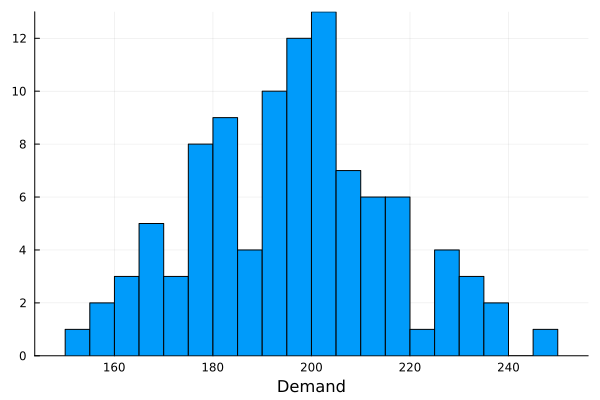

In [3]:
D = Distributions.TriangularDist(150.0, 250.0, 200.0) # Distribuição da demanda
N = 100 # Número de cenários
Ω = 1:N # Conjunto de cenários
P = fill(1 / N, N); # Probabilidade de cada cenário
d = sort!(rand(D, N)); # Demanda em cada cenário
StatsPlots.histogram(d; bins = 20, label = "", xlabel = "Demand")

## Decomposição: parte teórica

A formulação de otimização estocástica para o problema de venda de tortas é:
$$
\begin{aligned}
V = \max\limits_{x,y_\omega} \;\; & -2x + \mathbb{E}_\omega[5y_\omega - 0.1(x - y_\omega)] \\
  & y_\omega \le x              & \quad \forall \omega \in \Omega \\
  & 0 \le y_\omega \le d_\omega & \quad \forall \omega \in \Omega \\
  & x \ge 0.
\end{aligned}
$$

Vamos separar este problema em dois problemas, um para cada estágio.

O problema do **primeiro estágio** é calcular a quantidade de tortas a serem produzidas $\bar{x}$:
$$
\begin{aligned}
V = \max\limits_{x} \;\; & -2x + V_2(x) \\
  \text{s.a} \;\; & x \ge 0.
\end{aligned}
$$
Introduzimos a função $V_2$, que representa o valor esperado do segundo estágio, **dada** a decisão $x$ do primeiro estágio.
Apenas fazendo esta decomposição, não tornamos o problema significativamente mais simples, pois a função $V_2$ não tem uma expressão fácil.


O problema do **segundo estágio** é: dada a quantidade de tortas que foram produzidas $\bar{x}$, calcular o quanto vender e o quanto descartar para cada cenário $\omega$:
$$
\begin{aligned}
V_2(\bar{x}) = \max\limits_{y_\omega} \;\; & \mathbb{E}_\omega[5y_\omega - 0.1(\bar{x} - y_\omega)] \\
  & y_\omega \le \bar{x} & \quad \forall \omega \in \Omega \\
  & 0 \le y_\omega \le d_\omega & \quad \forall \omega \in \Omega\rlap{ .}
\end{aligned}
$$

Uma das razões de realizar essa decomposição temporal é que podemos, também, decompor o problema de segundo estágio em vários problemas menores, um para cada cenário $\omega$.
Isso dá origem à função $V_2(\bar{x}, \omega)$, que representa o valor esperado do segundo estágio, **dados** a decisão do primeiro estágio $\bar{x}$ e o cenário $\omega$:
$$
\begin{aligned}
V_2(\bar{x}, \omega) = \max\limits_{y_\omega} \;\; & 5y_\omega - 0.1(\bar{x} - y_\omega) \\
  & y_\omega \le \bar{x} \\
  & 0 \le y_\omega \le d_\omega\rlap{ .}
\end{aligned}
$$

<img src="assets/L_shaped.png" width="500">

Estes são problemas muito mais simples de ser resolvidos.

### As funções de lucro futuro

In [4]:
function solve_second_stage(x̅, d_ω)
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, 0 <= y_ω <= d_ω)
    @constraint(model, y_ω <= x̅)
    @objective(model, Max, 5 * y_ω - 0.1 * (x̅ - y_ω))
    optimize!(model)
    return (
        V = objective_value(model),
        u = value(y_ω),
    )
end

solve_second_stage(200, 170)

(V = 846.9999999999999, u = 170.0)

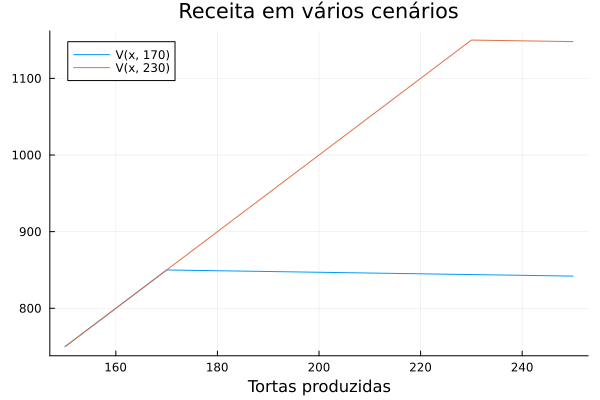

In [5]:
xs = 150:10:250
ys = [solve_second_stage(x, 170).V for x in xs]
Plots.plot(xs, ys, label = "V(x, 170)", xlabel = "Tortas produzidas", title = "Receita em vários cenários")
ys = [solve_second_stage(x, 230).V for x in xs]
Plots.plot!(xs, ys, label = "V(x, 230)")

### Exercícios

* Faça um gráfico de $V_2(\bar{x})$ para $\bar{x} \in [150, 250]$.
* É possível calcular uma expressão "analítica" para $y_\omega$ em função de $\bar{x}$ e $d_\omega$.
  Verifique que esta expressão é uma função linear por partes, e compare com a solução do problema de segundo estágio.

### Representando $V_2$ no primeiro estágio

A próxima etapa é encontrar uma representação conveniente para $V_2(x)$,
que permita calcular o ótimo do problema de primeiro estágio sem, necessariamente, calculá-la em todos os valores de $x$ possíveis.

Como $V_2(x, \omega)$ é **côncava** em $x$ (para cada $\omega$), ela está sempre "abaixo da tangente", ou seja:
$$
V_2(x, \omega) \le V_2(\bar{x}^k, \omega) + \nabla V_2(\bar{x}^k, \omega)^\top(x - \bar{x}^k),
$$
onde calculamos a tangente em $\bar{x}^k$.

Tomando o valor esperado de ambos os lados, temos o mesmo para a média $V_2(x)$:
$$ \begin{aligned}
V_2(x) = \mathbb{E}_\omega[V_2(x, \omega)] & \le \mathbb{E}_\omega[V_2(\bar{x}^k, \omega) + \nabla V_2(\bar{x}^k, \omega)^\top(x - \bar{x}^k)] \\
& = \mathbb{E}_\omega[V_2(\bar{x}^k, \omega)] + \mathbb{E}_\omega[\nabla V_2(\bar{x}^k, \omega)]^\top(x - \bar{x}^k) \\
& = V_2(\bar{x}^k) + \nabla V_2(\bar{x}^k)^\top(x - \bar{x}^k)
\end{aligned} $$
e usando vários pontos $\{\bar{x}^k\}$, obtemos então:
$$
\theta = \mathbb{E}_\omega[V_2(\bar{x}, \omega)] \le V_2(\bar{x}^k) + \nabla V_2(\bar{x}^k)^\top(x - \bar{x}^k) \quad \forall k.
$$

Estas desigualdades podem então ser usadas para construir um problema de otimização que aproxima o problema de primeiro estágio:
$$
\begin{aligned}
V^K = \max\limits_{x,\theta} \;\; & -2x + \theta \\
  & \theta \le V_2(\bar{x}^k) + \nabla V_2(\bar{x}^k)^\top(x - \bar{x}^k) & \quad k = 1,\ldots,K\\
  & x \ge 0.
\end{aligned}
$$
Note que introduzimos uma **variável auxiliar** $\theta$ para representar o valor esperado de $V_2$.

Como substituímos $V_2(x)$ por $\theta$, e usamos a aproximação linear por partes de $V_2(x)$,
este problema de otimização dá uma estimativa **otimista** do valor esperado de $V_2(x)$:
sabemos que $\theta$ será menor do que as tangentes usadas, mas pode haver outras a serem levadas em conta.
Ou seja, $V^K \ge V$, o valor ótimo do problema original.

Por outro lado, para cada $\bar{x}^k$ podemos calcular $V_2(\bar{x}^k)$ resolvendo o problema de segundo estágio para cada cenário $\omega$ e tomando a média, e com isto obtemos uma estimativa do lucro:
$$
\underline{V}_k := -2\bar{x}^k + V_2(\bar{x}^k) \leq V \quad \forall k,
$$
pois $V$ é o máximo em $x$ da expressão que definiu $\underline{V}_k$.

Vejamos dois exemplos fáceis:
* Se $\bar{x} = 150$, sempre vendemos tudo, então $V_2(150) = 150 \times 5 = 750$, e se tivéssemos um pouco mais, venderíamos quase sempre um pouco mais, logo a derivada é 5.
* Se $\bar{x} = 250$, vendemos sempre igual à demanda, e descartamos o resto, logo o lucro é $\mathbb{E}_\omega[5d_\omega - 0.1(250 - d_\omega)] = 5.1 \times 200 - 25 = 995$, e se tivéssemos um pouco menos, descartaríamos um pouco menos, logo a derivada é -0.1.

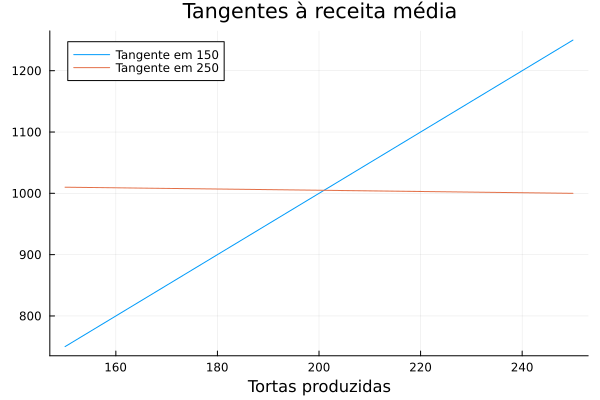

In [6]:
xs = 150:10:250
Plots.plot(xs, 5*150 .+ 5*(xs .- 150), label="Tangente em 150",
            xlabel="Tortas produzidas", title="Tangentes à receita média")
Plots.plot!(xs, 5*200 .- 0.1 * (xs .- 250), label="Tangente em 250")

### Calculando as tangentes

Para concluir a construção do problema de primeiro estágio, temos que calcular as derivadas de $V_2$ em $\bar{x}^k$.

Como a função $V_2$ é uma média, basta saber como calcular a derivada de cada $V_2(\bar{x}^k, \omega)$ em $\bar{x}^k$.
Ainda assim, este é um problema de otimização, e não temos uma expressão analítica para a solução, menos ainda para a derivada.

Felizmente, ao resolver o problema de otimização do segundo estágio para calcular $V_2(\bar{x}^k)$, também podemos calcular o multiplicador de Lagrange $\lambda^k_\omega$ associado à restrição $y_\omega \leq \bar{x}^k$ no cenário $\omega$.


In [7]:
function solve_second_stage(x̅, d_ω)
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, 0 <= y_ω <= d_ω)
    @constraint(model, c, y_ω <= x̅)
    @objective(model, Max, 5 * y_ω - 0.1 * (x̅ - y_ω))
    optimize!(model)
    return (
        V = objective_value(model),
        u = value(y_ω),
        λ = dual(c),
    )
end

solve_second_stage (generic function with 1 method)

### Multiplicadores de Lagrange e derivadas

Vejamos a relação entre os multiplicadores de Lagrange e as diferenças entre valores de $V_2(x, \omega)$.

Começamos com $x = 150$:

In [8]:
solve_second_stage(150, 170)

(V = 750.0, u = 150.0, λ = -5.1)

In [9]:
solve_second_stage(151, 170)

(V = 754.9999999999999, u = 151.0, λ = -5.1)

Note que a diferença entre o valor de $V_2(150, 170)$ e $V_2(151, 170)$ não corresponde ao multiplicador de Lagrange (que é -5.1 **em ambos os casos**, e portanto deveria dar o valor exato), mas à correção dele por $0.1$, devido ao valor de $\bar{x}$ também aparecer na função objetivo do problema.

O mesmo acontece em torno de $\bar{x} = 200$:

In [10]:
solve_second_stage(200, 170)

(V = 846.9999999999999, u = 170.0, λ = 0.0)

In [11]:
solve_second_stage(201, 170)

(V = 846.8999999999999, u = 170.0, λ = 0.0)

### Isolando a variável do primeiro estágio

Podemos utilizar uma formulação ligeiramente diferente do problema de cada cenário do segundo estágio:
$$ \begin{aligned}
V_2(\bar{x}, \omega) = \max\limits_{x,x^\prime_\omega,y_\omega} \;\; & 5y_\omega - 0.1x^\prime_\omega \\
  \text{s.a} \;\; & y_\omega \le x \\
  & x^\prime_\omega = x - y_\omega \\
  & 0 \le y_\omega \le d_\omega \\
  & x = \bar{x} & [\lambda_\omega]
\end{aligned} $$
onde incluímos uma variável $x^\prime_\omega$ para representar a diferença entre $\bar{x}$ e $y_\omega$ (eliminando $\bar{x}$ da função objetivo), e também substituímos todas as ocorrências de $\bar{x}$ por uma variável extra $x$, sujeita a uma restrição $x = \bar{x}$.

**Notação**: é comum indicar o multiplicador de Lagrange correspondente a uma restrição na mesma linha, entre colchetes.
Assim, $\lambda_\omega$ é o multiplicador de Lagrange associado à restrição $x = \bar{x}$.

Como agora a variável $\bar{x}^k$ aparece **apenas** nesta restrição do problema de otimização (e do lado direito, com coeficiente $1$),
o gradiente $\nabla V_2(\bar{x}^k, \omega)$ será de fato igual a $\lambda^k_\omega$, e portanto
$$
\nabla V_2(\bar{x}^k) = \mathbb{E}_\omega[ V_2(\bar{x}^k, \omega) ] = \mathbb{E}_\omega[\lambda^k_\omega].
$$

Com isto, temos uma nova formulação para a função do segundo estágio:

In [12]:
function solve_second_stage(x̅, d_ω)
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, x)
    @variable(model, x_prime >= 0)
    fix(x, x̅)
    @variable(model, 0 <= y_ω <= d_ω)
    @constraint(model, x_prime == x - y_ω)
    @constraint(model, y_ω <= x)
    @objective(model, Max, 5 * y_ω - 0.1 * x_prime)
    optimize!(model)
    return (
        V = objective_value(model),
        u = value(y_ω),
        λ = reduced_cost(x),
    )
end

solve_second_stage(200, 170)

(V = 847.0, u = 170.0, λ = -0.1)

In [13]:
solve_second_stage(150, 170)

(V = 750.0, u = 150.0, λ = 5.0)

## Decomposição: algoritmo e implementação

Para transformar estas ideias em um algoritmo, precisamos escolher uma sequência de pontos $\{x^k\}$ de forma que as aproximações por cima e por baixo convirjam.
Como o valor ótimo $V$ está entre elas, ele será o limite de ambas.

Um algoritmo, conhecido como **método de planos cortantes** (_cutting planes_) e também _"L-shaped"_ (Slyke e Wets, 1969), é o seguinte:

1. Construa o problema do primeiro estágio:
$$ \begin{aligned}
V^0 = \max\limits_{x,\theta} \;\; & -2x + \theta \\
  \text{s.a} \;\; & x \ge 0,
\end{aligned} $$
e o problema de segundo estágio:
$$ \begin{aligned}
V_2(\bar{x}, \omega) = \max\limits_{x^\prime,y_\omega} \;\; & 5y_\omega - 0.1x^\prime \\
  \text{s.a} \;\; & y_\omega \le x \\
  & x^\prime = x - y_\omega \\
  & 0 \le y_\omega \le d_\omega \\
  & x = \bar{x}.
\end{aligned} $$
2. O problema do primeiro estágio tem uma variável livre (sem restrições) $\theta$ na função objetivo.
   Para contornar este problema, é comum calcular (de forma aproximada) um limite superior para $\theta$.
   Neste exemplo, podemos usar o fato de que $V_2(x, \omega) \le 5d_\omega$ para obter $\theta \le 5\mathbb{E}_\omega[d_\omega]$.
3. Tome $k = 1$
4. Resolva o problema de primeiro estágio, obtendo uma solução viável $\bar{x}^k$.
5. Defina $\overline{V} = V^k$, o valor ótimo do problema de primeiro estágio.
6. Resolva o problema de segundo estágio $V_2(\bar{x}^k, \omega)$ para cada cenário $\omega$,
   e armazene os valores ótimos $v^k_\omega$ e os multiplicadores correspondentes $\lambda^k_\omega$.
7. Calcule as médias $v^k = \mathbb{E}_\omega[v^k_\omega]$ e $\lambda^k = \mathbb{E}_\omega[\lambda^k_\omega]$.
8. Calcule um limite inferior $\underline{V}^k = -2\bar{x}^k + v^k$.
9. Se $\underline{V}^k \approx \overline{V}$, RETORNE $\overline{V}$, $\underline{V}^k$ e $\bar{x}^k$.
10. Adicione uma nova restrição $\theta \le v^k + {\lambda^k}^\top (x - \bar{x}^k)$ ao problema de primeiro estágio.
11. Incremente $k$ e GOTO 4.

No nosso caso, o problema do primeiro estágio tem de fato uma solução inicial.
Em casos mais gerais, poderia acontecer de ele ser inviável (e daí o problema estocástico também será), ou ser ilimitado (ou seja, sem uma representação "boa" de $V_2$, uma solução poderia divergir para infinito e o problema aproximado ter valor $\infty$).
Estes casos devem ser tratados à parte.

### Etapa 1: Modelos de otimização

O primeiro estágio é:

In [14]:
first_stage = Model(HiGHS.Optimizer)
set_silent(first_stage)
@variable(first_stage, x >= 0)
@variable(first_stage, θ)
@objective(first_stage, Max, -2 * x + θ)
print(first_stage)

Agora, vamos fazer uma função para calcular o problema de segundo estágio:

In [15]:
function solve_second_stage(x̅, d_ω)
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, x)
    @variable(model, x_prime >= 0)
    fix(x, x̅)
    @variable(model, 0 <= y_ω <= d_ω)
    @constraint(model, x_prime == x - y_ω)
    @constraint(model, y_ω <= x)
    @objective(model, Max, 5 * y_ω - 0.1 * x_prime)
    optimize!(model)
    return (
        V = objective_value(model),
        u = value(y_ω),
        λ = reduced_cost(x),
    )
end

solve_second_stage(200, 170)

(V = 847.0, u = 170.0, λ = -0.1)

### Etapa 2: Limite inicial

In [16]:
θ_max = 5*sum(P .* d)
@constraint(first_stage, θ <= θ_max)

θ <= 981.9030241062164

### Etapas 3-11: o loop

- Tome $k = 1$
- Resolva o problema de primeiro estágio, obtendo uma solução viável $\bar{x}^k$.
- Defina $\overline{V} = V^k$, o valor ótimo do problema de primeiro estágio.
- Resolva o problema de segundo estágio $V_2(\bar{x}^k, \omega)$ para cada cenário $\omega$,
   e armazene os valores ótimos $v^k_\omega$ e os multiplicadores correspondentes $\lambda^k_\omega$.
- Calcule as médias $v^k = \mathbb{E}_\omega[v^k_\omega]$ e $\lambda^k = \mathbb{E}_\omega[\lambda^k_\omega]$.
- Calcule um limite inferior $\underline{V}^k = -2\bar{x}^k + v^k$.
- Se $\underline{V}^k \approx \overline{V}$, RETORNE $\overline{V}$, $\underline{V}^k$ e $\bar{x}^k$.
- Adicione uma nova restrição $\theta \le v^k + {\lambda^k}^\top (x - x^k)$ ao problema de primeiro estágio.
- Incremente $k$ e volte

In [17]:
kMax = 10
xs = Float64[]
ubs = Float64[]
lbs = Float64[]

for k in 1:kMax # Etapas 3 e 11
    println("Iteração $k")
    # Etapa 4: resolvendo o primeiro estágio
    optimize!(first_stage)
    xᵏ = value(x)
    println("  Novo candidato: = $xᵏ")
    push!(xs, xᵏ)
    # Etapa 5: atualizando o limite superior
    ub = objective_value(first_stage)
    println("  V̅ = $ub")
    push!(ubs, ub)
    
    # Etapa 6: resolver cada cenário do segundo estágio
    ret = [solve_second_stage(xᵏ, d[ω]) for ω in Ω]
    # Etapa 7: cálculo das médias
    vᵏ = sum(p * r.V for (p, r) in zip(P, ret))
    λᵏ = sum(p * r.λ for (p, r) in zip(P, ret))
    # Etapa 8: limite inferior
    lb = -2xᵏ + vᵏ
    println("  V̲ = $lb")
    push!(lbs, lb)
    # Etapa 9: teste de convergência
    if isapprox(lb, ub; atol = 1e-6)
        println("Achamos uma solução ótima (dentro das tolerâncias especificadas)!")
        break
    end

    # Etapa 10: adicionando o corte
    c = @constraint(first_stage, θ <= vᵏ + λᵏ * (x - xᵏ) )
    println("  Novo corte: $c")
end

Iteração 1
  Novo candidato: = 0.0
  V̅ = 981.9030241062164
  V̲ = 0.0
  Novo corte: -4.99999999999999 x + θ <= 0
Iteração 2
  Novo candidato: = 196.38060482124368
  V̅ = 589.1418144637291
  V̲ = 549.2942783396206
  Novo corte: -2.602999999999999 x + θ <= 430.87677363241096
Iteração 3
  Novo candidato: = 211.68891681667523
  V̅ = 558.5251904728659
  V̲ = 543.5423937766393
  Novo corte: -0.9710000000000003 x + θ <= 761.370289180998
Iteração 4
  Novo candidato: = 202.50828158614422
  V̅ = 552.9892674288557
  V̲ = 550.2807770786548
  Novo corte: -1.685000000000001 x + θ <= 614.07088577829
Iteração 5
  Novo candidato: = 199.5578563680603
  V̅ = 551.2101610223511
  V̲ = 550.6297164141201
  Novo corte: -2.1950000000000007 x + θ <= 511.71593442234825
Iteração 6
  Novo candidato: = 200.69598305086623
  V̅ = 550.8516511172672
  V̲ = 550.6995754505726
  Novo corte: -1.940000000000001 x + θ <= 562.7413344336244
Iteração 7
  Novo candidato: = 200.09960788735768
  V̅ = 550.7353579603832
  V̲ = 550.

Com isto, podemos acessar a solução ótima do problema de primeiro estágio, que é a quantidade de tortas a serem produzidas.

In [18]:
# O `for` termina adicionando uma restrição; por isso, devemos otimizar para obter o valor da decisão $x$
optimize!(first_stage)
x_opt  = value(x)

200.32758267868982

### Observando a convergência

Os limites superiores e inferiores vão se aproximando ao longo das iterações, mas os lucros reais $v^k = V_2(x^k)$ correspondentes às decisões $x^k$ podem oscilar.
Já os limites superiores $\overline{V}$ são sempre decrescentes, pois o problema de primeiro estágio tem cada vez mais restrições ao longo das iterações.

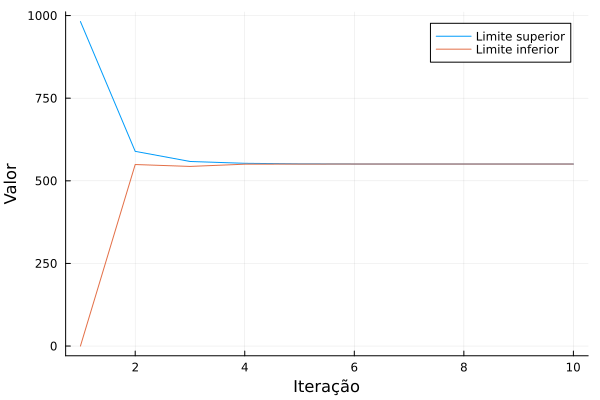

In [19]:
Plots.plot(1:kMax, ubs, label = "Limite superior", xlabel = "Iteração", ylabel = "Valor")
Plots.plot!(1:kMax, lbs, label = "Limite inferior")

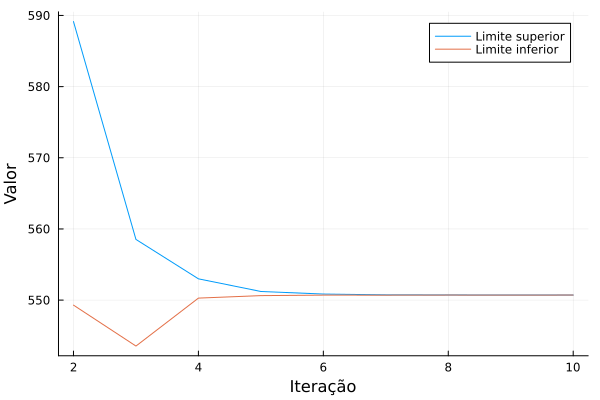

In [20]:
zoom = 2:kMax
Plots.plot(zoom, ubs[zoom], label = "Limite superior", xlabel = "Iteração", ylabel = "Valor")
Plots.plot!(zoom, lbs[zoom], label = "Limite inferior")

Vejamos também como as decisões mudam ao longo do algoritmo:

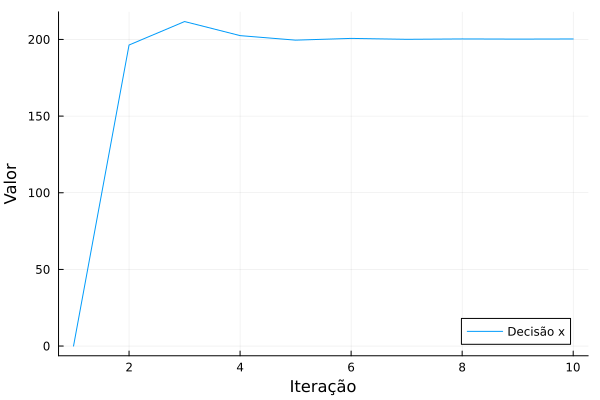

In [21]:
Plots.plot(1:kMax, xs, label = "Decisão x", xlabel = "Iteração", ylabel = "Valor")

### Observando a função de lucro futuro

Se mudarmos a função objetivo do problema de primeiro estágio, teremos um problema que calcula a função $V_2(x)$ pelas aproximações lineares por partes.

In [22]:
print(first_stage)

In [23]:
@objective(first_stage, Max, first_stage[:θ])
delete_lower_bound(x)
print(first_stage)

Resolvendo este problema para diferentes valores de $x$, podemos fazer um gráfico da função $\theta(x) = V_2^K(x)$.

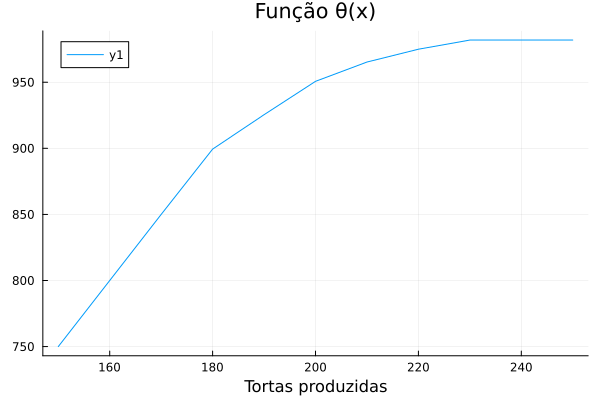

In [24]:
ys = []
for x̂ in 150:10:250
    fix(x, x̂)
    optimize!(first_stage)
    push!(ys, objective_value(first_stage))
end
Plots.plot(150:10:250, ys, xlabel = "Tortas produzidas", title = "Função θ(x)")

Retornando à formulação original do problema de primeiro estágio:

In [25]:
unfix(x) # Remove a restrição de igualdade
set_lower_bound(x, 0) # e restaura a restrição de não-negatividade
@objective(first_stage, Max, -2*x + first_stage[:θ]) # Restaura a função objetivo original
print(first_stage)

## Exercícios

* Modifique os preços e custos do problema e veja como a solução ótima muda
* Use outra distribuição da demanda
* Em geral, tortas são vendidas inteiras (ou em fatias de uma fração fixa).
  Exija que a variável $x$ do primeiro estágio seja inteira, usando
  `@variable(first_stage, x >= 0, Int)`, e veja como a solução muda.
* O limite superior que usamos foi "esperto".
  O que acontece se você usar um inválido (como `-100`) ou um grande demais (como `1e12`)?

## Melhorando a performance

A função que calcula o segundo estágio está correta, mas ela é chamada muitas vezes, e faz bastante trabalho repetido.
Uma das mudanças que podemos fazer é construir o problema de segundo estágio apenas uma vez, e depois alterar os dados para cada cenário.

In [26]:
second_stage = Model(HiGHS.Optimizer)
set_silent(second_stage)
@variable(second_stage, x_in)
@variable(second_stage, x_prime >= 0)
@variable(second_stage, 0 <= y_ω) # Não temos d_ω aqui, pois muda a cada cenário!
@constraint(second_stage, x_prime == x_in - y_ω)
@constraint(second_stage, y_ω <= x_in)
@objective(second_stage, Max, 5 * y_ω - 0.1 * x_prime)

5 y_ω - 0.1 x_prime

In [27]:
function solve_second_stage(second_stage, x̅, d_ω)
    fix(second_stage[:x_in], x̅)
    set_upper_bound(second_stage[:y_ω], d_ω)
    optimize!(second_stage)
    return (
        V = objective_value(second_stage),
        u = value(y_ω),
        λ = reduced_cost(x_in),
    )
end

solve_second_stage(second_stage, 200, 170)

(V = 847.0, u = 170.0, λ = -0.1)

Note que usamos `second_stage[:x_in]` e `second_stage[:y_ω]` para acessar as variáveis do segundo estágio.

Neste exemplo específico, isto é possível porque sabemos o nome das variáveis.
Em casos mais gerais, o `JuMP` possui um dicionário de **extensão** associado a cada problema de otimização, que permite salvar e recuperar dados úteis.
Por exemplo, ao declarar o problema de primeiro estágio, o usuário pode identificar as variáveis que serão usadas no segundo estágio (adicionando em algum lugar previamente estabelecido pela biblioteca que você está escrevendo), e desta forma o seu código saberá onde encontrá-las.

## Mais exercícios

Podemos usar uma medida de risco neste algoritmo.
  Existem duas formas de fazer isto:
  - Podemos modificar a forma de construir o corte para aproximar $V_2(x) = \rho(V_2(x, \omega))$ em vez de $\mathbb{E}(V_2(x, \omega))$.
    Em vez de usar a média dos valores ótimos e multiplicadores ótimos, teremos que calcular o peso de cada cenário (que pode mudar com as iterações).
  - Podemos criar uma variável $\theta_\omega$ para cada cenário, e calcular a medida de risco no problema de primeiro estágio:
  $$ \begin{aligned}
  V^K = \max\limits_{x,\theta} \;\; & -2x + \theta \\
    & \theta \le \rho(\theta_\omega) & \\
    & \theta_\omega \le M_\omega & \quad \forall \omega \\
    & \theta_\omega \le V_2(x^k, \omega) + \nabla V_2(x^k, \omega)^\top(x - x^k) & \quad \forall \omega, \forall k \\
    & x \ge 0.
  \end{aligned} $$

Implemente a segunda forma para o CVaR, e veja como a solução muda.

In [28]:
# Função do CVaR da aula anterior
function apply_cvar(model, Z, γ)
    # Problema do CVaR: variáveis auxiliares ξ, e u
    @variable(model, ξ)
    @variable(model, u[ω in Ω] >= 0)
    @constraint(model, [ω in Ω], u[ω] >= ξ - Z[ω])
    # O "CVaR" não é nem uma variável de decisão
    # nem uma restrição do problema,
    # mas uma parte da função objetivo.
    @expression(model, cvar, ξ - 1 / γ * sum(P[ω] * u[ω] for ω in Ω))
    return cvar
end

apply_cvar (generic function with 1 method)